# 1. Data Acquisition and Preprocessing

In [ ]:
# Data manipulation
import pandas as pd

# Libraries for API querying
import json
import requests
from pprint import pprint

# Imports for image scaling and file access
import os
from PIL import Image
from tqdm import tqdm

# For splitting into train and test
import random
import shutil

# For EDA
import matplotlib.pyplot as plt
from collections import Counter

# For calculations
import math

In [ ]:
# For PyTorch
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

To be loading API keys and related secret value we will be using .env files.

In [ ]:
from dotenv import load_dotenv

load_dotenv()

A helper function which will be useful later on in nutrition data retrieval will be to get a list of all the food names present in our dataset.

In [ ]:
def get_food_names():
    data_path = 'food-128'
    food_names = []

    # Extract food names from folders
    for food_name in os.listdir(data_path):
        full_path = os.path.join(data_path, food_name)
        if os.path.isdir(full_path):
            food_names.append(food_name.replace('_', ' '))
    return food_names
print(get_food_names())

Downscaling the images will help massively in getting a working model without needing to use the full image data. The method to do so is shown below.

In [ ]:
# Downscale images (ChatGPT)
# Take our raw images

# Source and target directories
SRC_DIR = "images"        # original images folder with class subfolders
DST_DIR = "food-128"      # output folder

size = (128, 128)  # target resolution

# Create output root directory
os.makedirs(DST_DIR, exist_ok=True)

# Loop through every class folder
for class_name in os.listdir(SRC_DIR):
    src_class_path = os.path.join(SRC_DIR, class_name)
    dst_class_path = os.path.join(DST_DIR, class_name)

    # Skip non-directories (just in case)
    if not os.path.isdir(src_class_path):
        continue

    os.makedirs(dst_class_path, exist_ok=True)

    # Resize each image
    for img_name in tqdm(os.listdir(src_class_path), desc=f"Resizing {class_name[:20]}"):
        src_img_path = os.path.join(src_class_path, img_name)
        dst_img_path = os.path.join(dst_class_path, img_name)

        try:
            img = Image.open(src_img_path).convert("RGB")
            img = img.resize(size, Image.Resampling.BILINEAR)
            img.save(dst_img_path, quality=90)
        except Exception as e:
            print(f"Skipped {src_img_path}: {e}")

print("All images resized to 128x128 and saved in food-128")

### FoodData Central API Loading

For loading the API data, we'll first need to define some constants which will be used through data retrieval.

In [ ]:
# API Setup
FDC_BASE_URL = 'https://api.nal.usda.gov/fdc/v1'
FDC_API_KEY = os.getenv('FDC_API_KEY')

To search the FoodData Central database, we'll use the following helper functions:

In [ ]:
def search_food(query, data_type='Survey (FNDDS)', limit=10):
    # data_type can be any of 'Branded', 'Foundation', 'Survey (FNDDS)', 'SR Legacy'
    parameters = {
        'api_key': FDC_API_KEY,
        'query': query,
        'dataType': data_type,
        'pageSize': limit
    }
    response = requests.get(url=f'{FDC_BASE_URL}/foods/search', params=parameters)
    response.raise_for_status()
    return response.json()


def get_calories(food):
    for nutrient in food.get('foodNutrients', []):
        # TODO: test if {foodNutrientId': 34350077, nutrientName: 'Energy'} is the correct dict
        if nutrient.get('nutrientName') == 'Energy' and nutrient.get('unitName') == 'KCAL':
            return nutrient['value']
    return None


def simplify_results(data):
    foods = data.get('foods', [])
    result_foods = []
    for food in foods:
        calories = get_calories(food)
        if calories is not None:
            result_foods.append({
                'name': food['description'],
                'calories': calories
            })
    return result_foods


def estimate_calories_from_results(results, top_n=5):
    if not results:
        return None

    # Get the first `top_n` calorie values that aren't None
    calories = [r['calories'] for r in results if r.get('calories') is not None][:top_n]
    if not calories:
        return None

    return round(sum(calories) / len(calories), 1)

To test the helper functions' ability to query the API, we can search with a given dish name.

In [ ]:
# Since the API calls could fail, use a try except block
try:
    food = input('Type a food:')
    response = search_food(food)
    simplified = simplify_results(response)
    print(len(simplified))
    pprint(simplified)
except Exception as e:
    print('Error:', e)

Now, we'll need to refine this data to contain only the relevant caloric information for the foods in our dataset. An important aspect of this to note is that the FoodData Central API is limited to 1000 requests per hour by IP address, and will block an IP address for one hour if this limit is exceded.

In [ ]:
try:
    food_names = get_food_names()
    all_calorie_data = []
    for food in food_names:
        response = search_food(food)
        simplified = simplify_results(response)
        estimate = estimate_calories_from_results(simplified, top_n=5)
        print(f"\n{food}: ~{estimate} kcal/100g")
        all_calorie_data.append({
            'food': food,
            'estimate_calories_per_100g': estimate,
            'results': simplified
        })
except Exception as e:
    print("Error:", e)


With the previous code block, we now have a list of the results of the keyword search for all 101 dishes along with an estimate for kcal/100g. However, some of these contained no entries at all.

In [ ]:
# Count and record missing dishes
missing_dishes = []
for i in range(len(food_names)):
    if all_calorie_data[i].get('estimate_calories_per_100g') == None:
        missing_dishes.append(food_names[i])

print('Missing dish count:', len(missing_dishes))
pprint(missing_dishes)

To supplement the data which doesn't have an entry in the FoodData Central API, we'll be using the Nutritionix API.

In [ ]:
NUTRITIONIX_URL = 'https://trackapi.nutritionix.com/v2/natural/nutrients'
NUTRITIONIX_APP_ID = os.getenv('NUTRITIONIX_APP_ID')
NUTRITIONIX_APP_KEY = os.getenv('NUTRITIONIX_APP_KEY')

In [ ]:
def get_calories_nutritionix(query):
    headers = {
        'x-app-id': NUTRITIONIX_APP_ID,
        'x-app-key': NUTRITIONIX_APP_KEY,
        'Content-Type': 'application/json'
    }
    body = {
        "query": query
    }

    try:
        response = requests.post(NUTRITIONIX_URL, headers=headers, json=body)
        response.raise_for_status()
    except Exception as e:
        print('Error:', e)
        return None

    data = response.json()

    foods = data.get("foods", [])
    if not foods:
        print("No nutrition data found for", query)
        return None

    # Extract calorie info from first result
    f = foods[0]
    cal = f.get("nf_calories", 0)
    weight = f.get("serving_weight_grams", 100)
    cal_per_100g = cal * (100 / weight)

    return round(cal_per_100g, 1)

When storing this with the rest of our data which had FoodData Central simplified results included, we'll use `None` as the value for the `'results'` key in the food dictionary.

In [ ]:
for food in missing_dishes:
    estimate = get_calories_nutritionix(food)
    all_calorie_data.append({
            'food': food,
            'estimate_calories_per_100g': estimate,
            'results': None
        })
    print(f'{food}: ', estimate)

In [ ]:
for food_entry in all_calorie_data:
    pprint(food_entry)

For easier use later on, we'll save the calorie estimate information to a CSV file.

In [ ]:
# Create a dataframe then store to CSV
rows = [
    {'food': entry['food'], 'kcal/100g': entry['estimate_calories_per_100g']}
    for entry in all_calorie_data
]

calorie_df = pd.DataFrame(rows, columns=['food', 'kcal/100g'])
print(calorie_df.info())

calorie_df.to_csv('data/calories.csv', index=False)

Turn Image Data Into Train and Test Sets


In [ ]:
SRC_DIR = 'food-128'

TRAIN_DIR = 'food-128-split/train'
TEST_DIR = 'food-128-split/test'

# Output directories
os.makedirs(TRAIN_DIR)
os.makedirs(TEST_DIR)

cntr = 0
# Loop through each food subclass
for class_name in os.listdir(SRC_DIR):
    class_path = os.path.join(SRC_DIR, class_name)

    # Ensure its a folder
    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        # Shuffle images
        random.shuffle(images)

        # Set splitting point
        split_idx = int(len(images) * 0.8)

        train_images = images[:split_idx]
        test_images = images[split_idx:]

        # Create new food folders in train and test
        train_class_dir = os.path.join(TRAIN_DIR, class_name)
        test_class_dir = os.path.join(TEST_DIR, class_name)
        os.makedirs(train_class_dir)
        os.makedirs(test_class_dir)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_class_dir, img))
        for img in test_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(test_class_dir, img))

        cntr += 1
        print(f"{cntr}. Processesed {class_name}: {len(train_images)} train, {len(test_images)} test")

print("Dataset split successfully.")


Convert Images to new format using PyTorch

In [ ]:
# Image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        # These numbers come from ImageNet
        # Represent mean and standard deviation values for RGB based on a massive dateset of color distribution in natural images
        mean = [0.485, 0.456, 0.406],
        std = [0.229, 0.224, 0.225]
    )
])

# Load training and test sets
train_dataset = datasets.ImageFolder(root = 'food-128-split/train', transform = transform)
test_dataset = datasets.ImageFolder(root = 'food-128-split/test', transform = transform)

# Create PyTorch data loaders for later
train_data = DataLoader(
    train_dataset,
    batch_size = 32, # use 32 images per batch
    shuffle = True, # shuffle training data each time to not get false patterns
    num_workers = 4 # use 4 CPU threads in parallel to speed up work
)

test_data = DataLoader(
    test_dataset,
    batch_size = 32, # same as above
    shuffle = False, # don't shuffle test data for consistent benchmarks
    num_workers = 4 # same as above
)

# Verify stuff
class_cnt = len(train_dataset.classes)
# Get class count
print(f"Num Classes: {class_cnt}")
# See a few just to verify names saved correctly
print(f"Sample Classes: {train_dataset.classes[:10]}")


# 2. Exploratory Data Analysis


## Class Calorie Estimate EDA

In [ ]:
# Calorie data loading and summary statistics
CALORIE_FILE_PATH = 'data/calories.csv'
calorie_df = pd.read_csv(CALORIE_FILE_PATH)

print(calorie_df.info())
print(calorie_df.describe())
print(calorie_df.head(5))

In [ ]:
# Class Calorie Visualization
# Begin by sorting df by 'kcal/100g'
calorie_df.sort_values('kcal/100g', ascending=False, inplace=True)
calorie_df.reindex()

# Create bar chart of the kcal/100g estimates for each food
plt.figure(figsize=(5, 18))
plt.title('Bar Chart of Calorie Estimates')
plt.barh(calorie_df['food'], calorie_df['kcal/100g'])
plt.ylabel('Food Name')
plt.xlabel('Estimated kcal/100g')
plt.margins(y = 0.005)

plt.show()

## Image Data EDA
Generate visuals for the average pixel values of each food class.

In [ ]:
# Convert Images to tensor (fancy 4D array)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create dataset using this transform
dataset = datasets.ImageFolder(root='food-128-split/train', transform = transform)

# Get names of all foods
food_names = dataset.classes
total_num_foods = len(food_names) # should always be 101 but just in case

# 7 distinct food to visualize
selected_classes = [
    'sushi',
    'guacamole',
    'spaghetti_bolognese',
    'macarons',
    'chocolate_cake',
    'caesar_salad',
    'strawberry_shortcake',
    'beef_carpaccio'
]
food_count = len(selected_classes)

# Map class names to integer labels used by ImageFolder
selected_indices = [dataset.class_to_idx[c] for c in selected_classes]

# Filter dataset to only images with those labels
subset_indices = [
    i for i, (_, label) in enumerate(dataset.samples)
    if label in selected_indices
]
subset_dataset = Subset(dataset, subset_indices) # create subset of just selected indices

# Create data loader because its much faster
subset_loader = DataLoader(
    subset_dataset,
    batch_size=32,   # process 32 images at once
    shuffle=False,   # don't randomize order for this
    num_workers=4    # load using 4 CPU threads in parallel
)

# Get tensors ready to find averages
H, W = 128, 128
# Track sum of R,G,B values for each pixel position
# Torch.zeros is 4D array we can use to keep values for each pixel distinct
sums = torch.zeros((food_count, 3, H, W))
# Keep track of how many images you've seen in current food class (again should always be 101 for our case)
counts = torch.zeros(food_count)
# Keep track of running sum of squares
sum_sq = torch.zeros((food_count, 3, H, W))

# Map original labels (0-100) to new compact label (0..food_count-1)
class_map = {orig_label: i for i, orig_label in enumerate(selected_indices)}

# Load through batches and add up pixel values
for images, labels in subset_loader: # images is tensor of batch size, 3, H, W --- lables is tensor of batch size with label for each image (will be the same label except when transitioning between food types)
    for i in range(images.size(0)):  # iterate through each image in batch
        label = labels[i].item() # get current image label
        if label in class_map:
            idx = class_map[label] # get idx in new smaller array
            sums[idx] += images[i] # add current image pixel values
            counts[idx] += 1 # track that we've added another image worth of pixels for later division
            sum_sq[idx] += images[i] ** 2

# Calculate average image (pixel-wise division)
# view reshapes counts into food_count, 1, 1, 1 so it works correctly when dividing into 4D sums tensor
avg_images = (sums / counts.view(-1, 1, 1, 1))

# Pixel-wise standard deviation
std_images = torch.sqrt((sum_sq / counts.view(-1, 1, 1, 1)) - (avg_images ** 2))

# Get std between different classes
interclass_std = torch.std(avg_images, dim=0)

# Calculate average pixel for each average image
avg_pixels = avg_images.mean(dim=(2, 3)) # avg_pixels is a tensor of batch size, 3, where each of the values are the means from dims H and W or avg_images

# Visualize average images
fig, axes = plt.subplots(math.ceil(food_count / 2), 2, figsize=(5, math.ceil(food_count / 2) * 2.5))
axes = axes.flatten()

for i, orig_label in enumerate(selected_indices):
    avg_img = avg_images[i].permute(1, 2, 0).numpy()  # Pytorch keeps images in Color, Height, Width, Order but matplotlib uses Height, Width, Color
    axes[i].imshow(avg_img)
    axes[i].set_title(food_names[orig_label], fontsize=12)
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Visualize average pixel channel values
fig, axes = plt.subplots(math.ceil(food_count / 2), 2, figsize=(6, math.ceil(food_count / 2) * 3))
axes = axes.flatten()

for i, orig_label in enumerate(selected_indices):
    channel_names = ['R', 'G', 'B']
    values = [avg_pixels[i, 0], avg_pixels[i, 1], avg_pixels[i, 2]]
    colors = ['red', 'green', 'blue']

    axes[i].bar(channel_names, values, color=colors)
    axes[i].set_title(food_names[orig_label])
    axes[i].set_xlabel('Color Channel')
    axes[i].set_ylabel('Value')
    axes[i].set_xmargin(0.1)
    axes[i].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Compute overall std value for each class
class_std_values = std_images.mean(dim=(1, 2, 3))

# Plot std values for deviation in average color between classes
# Possible future improvement could be using a circlular subset of the image to get the average color to avoid background noise
plt.figure(figsize=(8, 4))
plt.barh([food_names[i] for i in selected_indices], class_std_values.numpy())
plt.xlabel("Average Standard Deviation")
plt.title("Overall Color Variability per Food Class")
plt.tight_layout()
plt.show()

# Convert to numpy image and reorder to HWC for matplotlib
interclass_std_img = interclass_std.permute(1, 2, 0).numpy()
# Normalize for better contrast (to highlight areas with most deviation)
interclass_std_img = interclass_std_img / interclass_std_img.max()

plt.figure(figsize=(4, 4))
plt.imshow(interclass_std_img)
plt.title("Standard Deviation Across Classes")
plt.axis("off")
plt.show()

Basic Numerical Summaries for Entire Data

In [ ]:
# Number of channels and image dimensions (assume all images have same shape)
sample_img, _ = dataset[0]
num_channels, H, W = sample_img.shape

# Count images per class
labels = [label for _, label in dataset]
counts_per_class = Counter(labels)

# Map label index to class name
class_names = dataset.classes

# Print summary
print(f"Total images: {len(dataset)}")
print(f"Image shape: {num_channels} channels, {H}x{W} pixels")
print("Number of images per class:")
for label, count in counts_per_class.items():
    print(f"  {class_names[label]}: {count}")

# 3. Model Fitting

## Convolutional Neural Network (CNN)
Since we're working with 2D image data, using a CNN for classification is a common choice.

### PyTorch

In [5]:
import torch.nn as nn
import torch.optim as optim

First we will define a basic CNN using PyTorch's Sequential model structure.

In [ ]:
# Defining the CNN architecture

# Layer filter counts
num_conv1 = 32
num_conv2 = 64
num_conv3 = 128
num_conv4 = 256
num_hidden5 = 512
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size
padding = 1

model = nn.Sequential(
    # Block 1
    #   Using in_channels=3 because of the three color channels. Each filter has each dimension halved.
    nn.Conv2d(in_channels=3, out_channels=num_conv1, kernel_size=k_size, padding=padding),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=p_size),

    # Block 2
    nn.Conv2d(in_channels=num_conv1, out_channels=num_conv2, kernel_size=k_size, padding=padding),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=p_size),

    # Block 3
    nn.Conv2d(in_channels=num_conv2, out_channels=num_conv3, kernel_size=k_size, padding=padding),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=p_size),

    # Block 4
    nn.Conv2d(in_channels=num_conv3, out_channels=num_conv4, kernel_size=k_size, padding=padding),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=p_size),

    # Classification
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    nn.Flatten(),
    nn.Linear(in_features=num_conv4 * (image_shape // 2 ** num_convs) ** 2, out_features=num_hidden5),
    nn.ReLU(),
    nn.Linear(in_features=num_hidden5, out_features=num_output)
)

In [ ]:
# Training the CNN

# Move to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

# Define criterion and optimizer to use in training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 2

for epoch in range(num_epochs):
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_data):
        images = images.to(device, dtype=torch.float32)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print("Finished training")


### TensorFlow Rewrite

In [2]:
!unzip -q /content/drive/MyDrive/food-128.zip

In [ ]:
import os
import shutil
import random
from pathlib import Path

# Set random seed for reproducibility
random.seed(42)

# Original dataset folder
data_dir = Path("food-128")  # change to your dataset path

# Target folders
split_dir = Path("food-128-split")
(train_dir := split_dir / "train").mkdir(parents=True, exist_ok=True)
(val_dir := split_dir / "val").mkdir(parents=True, exist_ok=True)
(test_dir := split_dir / "test").mkdir(parents=True, exist_ok=True)

# Loop over classes
for class_name in os.listdir(data_dir):
    class_path = data_dir / class_name
    if not class_path.is_dir():
        continue

    # Shuffle images
    images = list(class_path.glob("*"))
    random.shuffle(images)

    # Split counts
    n_total = len(images)
    n_train = 700
    n_val   = 150
    n_test  = 150

    # Check if class has at least 1000 images
    if n_total < 1000:
        raise ValueError(f"Class {class_name} has only {n_total} images!")

    # Assign images
    train_imgs = images[:n_train]
    val_imgs   = images[n_train:n_train+n_val]
    test_imgs  = images[n_train+n_val:n_train+n_val+n_test]

    # Create class subfolders
    for folder in [train_dir, val_dir, test_dir]:
        (folder / class_name).mkdir(parents=True, exist_ok=True)

    # Copy images
    for img in train_imgs:
        shutil.copy(img, train_dir / class_name / img.name)
    for img in val_imgs:
        shutil.copy(img, val_dir / class_name / img.name)
    for img in test_imgs:
        shutil.copy(img, test_dir / class_name / img.name)

print("70/15/15 split completed.")

70/15/15 split completed.


In [3]:
import tensorflow as tf

# CNN Layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, GlobalAveragePooling2D

# Data Loading
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import split_dataset
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import numpy as np

In [30]:
# TensorFlow Data Loading Pipeline
batch_size = 32
img_height = 128
img_width = 128
seed = 42
data_dir = '/content/food-128-split'

# Load datasets
train_data = image_dataset_from_directory(
    f"{split_dir}/train",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True
)

val_data = image_dataset_from_directory(
    f"{split_dir}/val",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_data = image_dataset_from_directory(
    f"{split_dir}/test",
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalize
normalization_layer = Rescaling(1./255)

# Create normalized [0,1] data for custom CNNs
cnn_train = train_data.map(lambda x, y: (normalization_layer(x), y))
cnn_val   = val_data.map(lambda x, y: (normalization_layer(x), y))
cnn_test  = test_data.map(lambda x, y: (normalization_layer(x), y))

# Create normalized [-1,1] data for MobileNetV2
mobilenet_train = train_data.map(lambda x, y: (preprocess_input(x), y))
mobilenet_val   = val_data.map(lambda x, y: (preprocess_input(x), y))
mobilenet_test  = test_data.map(lambda x, y: (preprocess_input(x), y))

class_names = train_data.class_names
print(len(class_names))
print(class_names)


Found 70700 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
Found 15150 files belonging to 101 classes.
101
['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huev

In [ ]:
for image_batch, labels_batch in train_data:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

In [31]:
# Evaluate the model
def evaluate_model(model, history, test_data):
    loss, accuracy = model.evaluate(test_data)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    #plt.show()

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

def evaluate_model_test(model, test_data):
    loss, accuracy = model.evaluate(test_data)
    print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

#### Architecture 1

474/474 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.1030 - loss: 12.5345
Test Loss: 12.5775, Test Accuracy: 0.1043


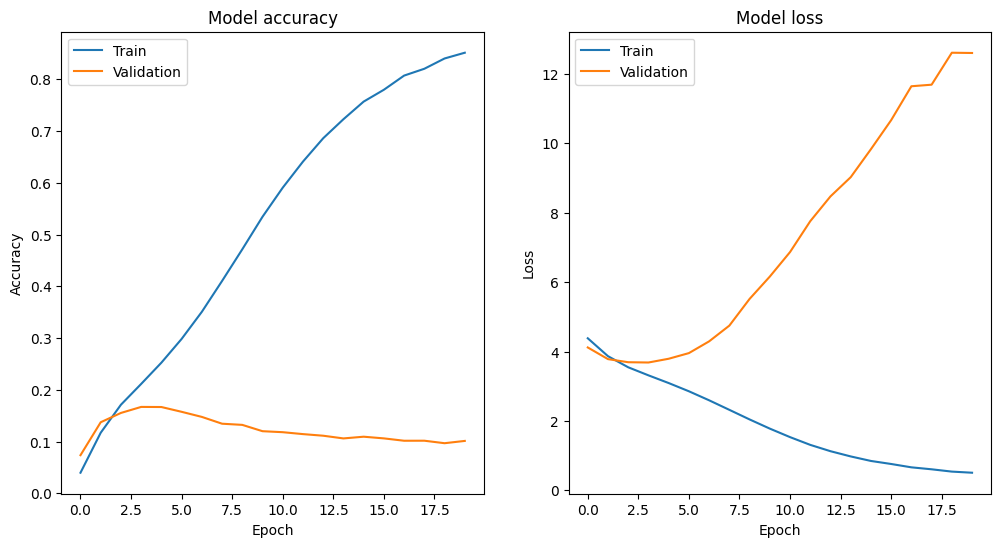

In [13]:
# Defining the CNN architecture in tensorflow

# Layer filter counts
num_conv1 = 32
num_conv2 = 64
num_conv3 = 128
num_conv4 = 256
num_hidden5 = 512
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size
padding = 1

model = Sequential([

    # Block 1
    Conv2D(num_conv1, kernel_size=(k_size, k_size), activation='relu', input_shape=(image_shape, image_shape, 3), padding='same'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 2
    Conv2D(num_conv2, kernel_size=(k_size, k_size), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 3
    Conv2D(num_conv3, kernel_size=(k_size, k_size), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 4
    Conv2D(num_conv4, kernel_size=(k_size, k_size), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Classification Head
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    Flatten(),
    Dense(num_hidden5, activation='relu'),
    Dense(num_output, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit the model to the data
num_epochs = 20

history = model.fit(
    cnn_train,
    validation_data=cnn_val,
    epochs=num_epochs
)

evaluate_model(model, history, cnn_test)

#### Architecture 2

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     8,389,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 101)            │        51,813 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 8,833,317 (33.70 MB)

 Trainable params: 8,831,333 (33.69 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.0679 - loss: 4.4338 - val_accuracy: 0.1580 - val_loss: 3.7101
Epoch 2/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.1864 - loss: 3.4715 - val_accuracy: 0.1424 - val_loss: 4.0105
Epoch 3/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.2626 - loss: 3.0569 - val_accuracy: 0.2871 - val_loss: 2.9491
Epoch 4/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.3336 - loss: 2.7015 - val_accuracy: 0.3107 - val_loss: 2.8410
Epoch 5/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4078 - loss: 2.3408 - val_accuracy: 0.3027 - val_loss: 3.0122
Epoch 6/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.4875 - loss: 1.9524 - val_accuracy: 0.2964 - val_loss: 3.0308
Epoch 7/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.5697 - loss: 1.5862 - val_accuracy: 0.3168 - val_loss: 3.1284
Epoch 8/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step - accuracy: 0.6553 - loss: 

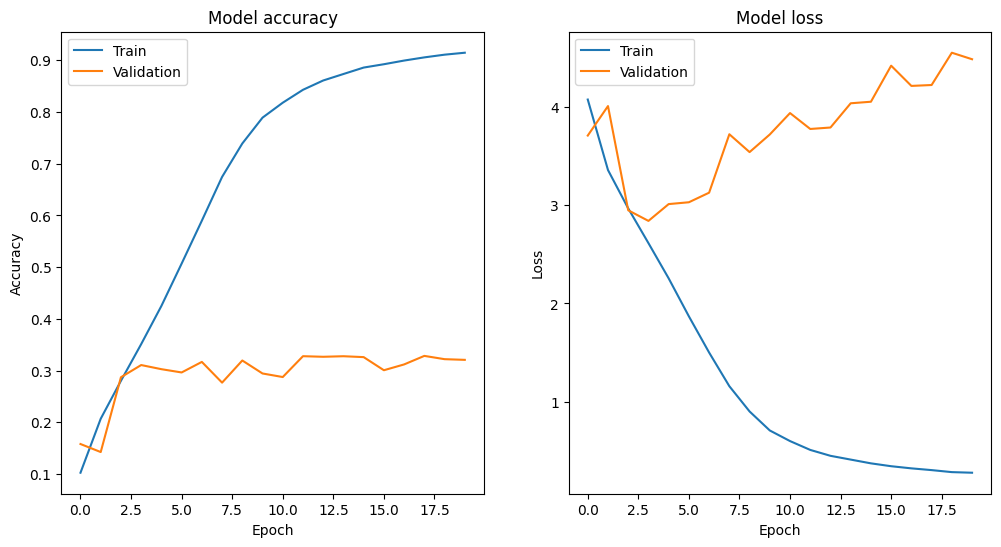

In [17]:
# Define CNN architecture 2

# Layer filter counts
num_conv1 = 32
num_conv2 = 64
num_conv3 = 128
num_conv4 = 256
num_hidden5 = 512
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size
padding = 1

model = Sequential([

    # Block 1
    Conv2D(num_conv1, kernel_size=(k_size, k_size), input_shape=(image_shape, image_shape, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 2
    Conv2D(num_conv2, kernel_size=(k_size, k_size), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 3
    Conv2D(num_conv3, kernel_size=(k_size, k_size), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 4
    Conv2D(num_conv4, kernel_size=(k_size, k_size), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Classification Head
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    Flatten(),
    Dense(num_hidden5),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_output, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit the model to the data
num_epochs = 20

# Fit the model to the data
num_epochs = 20

history = model.fit(
    cnn_train,
    validation_data=cnn_val,
    epochs=num_epochs
)

evaluate_model(model, history, cnn_test)

#### Architecture 3

This architecture is more structured and (aside from the lack of global average pooling) follows a VGG-Net style. This architecture is here only to show the iterative process. This would take a very long time to tune because the calssification head dense layer is absolutely massive (~8 million parameters).

In [ ]:
# Define CNN architecture 3

# Layer filter counts
num_conv1 = 64
num_conv2 = 128
num_conv3 = 256
num_conv4 = 512
num_hidden5 = 256
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size
padding = 1

model = Sequential([

    # Block 1
    Conv2D(num_conv1, kernel_size=(k_size, k_size), padding='same',
           kernel_initializer='he_normal', input_shape=(image_shape, image_shape, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv1, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 2
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 3
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 4
    Conv2D(num_conv4, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv4, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Classification Head
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    Flatten(),
    Dense(num_hidden5),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_output, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit the model to the data
num_epochs = 20

history = model.fit(
    cnn_train,
    validation_data=cnn_val,
    epochs=num_epochs
)

evaluate_model(model, history, cnn_test)

#### Architecture 4

This almost the same as architecture 3 but uses global average pooling in the classification head instead. This model is still completely infeasible to train on the hardware we have, but is here as a proof of concept.

In [ ]:
# Define CNN architecture 4

# Layer filter counts
num_conv1 = 64
num_conv2 = 128
num_conv3 = 256
num_conv4 = 512
num_hidden5 = 256
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size

model = Sequential([

    # Block 1
    Conv2D(num_conv1, kernel_size=(k_size, k_size), padding='same',
           kernel_initializer='he_normal', input_shape=(image_shape, image_shape, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv1, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 2
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 3
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 4
    Conv2D(num_conv4, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv4, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Classification Head
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    GlobalAveragePooling2D(),
    Dense(num_hidden5, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_output, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit the model to the data
num_epochs = 20

history = model.fit(
    cnn_train,
    validation_data=cnn_val,
    epochs=num_epochs
)

evaluate_model(model, history, cnn_test)

#### Architecture 5

This is a slimmed down version of architecture 4, with only 3 blocks and with halfed filter counts.

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             

 Total params: 318,853 (1.22 MB)

 Trainable params: 317,701 (1.21 MB)

 Non-trainable params: 1,152 (4.50 KB)

Epoch 1/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 50s 16ms/step - accuracy: 0.0399 - loss: 4.5144 - val_accuracy: 0.0881 - val_loss: 4.0232
Epoch 2/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.1123 - loss: 3.8476 - val_accuracy: 0.1475 - val_loss: 3.6105
Epoch 3/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.1684 - loss: 3.5190 - val_accuracy: 0.1728 - val_loss: 3.4865
Epoch 4/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2144 - loss: 3.2891 - val_accuracy: 0.2312 - val_loss: 3.1738
Epoch 5/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2460 - loss: 3.1242 - val_accuracy: 0.1928 - val_loss: 3.4231
Epoch 6/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2717 - loss: 2.9981 - val_accuracy: 0.2404 - val_loss: 3.2397
Epoch 7/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.2934 - loss: 2.8862 - val_accuracy: 0.2957 - val_loss: 2.8911
Epoch 8/20
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 25s 11ms/step - accuracy: 0.3118 -

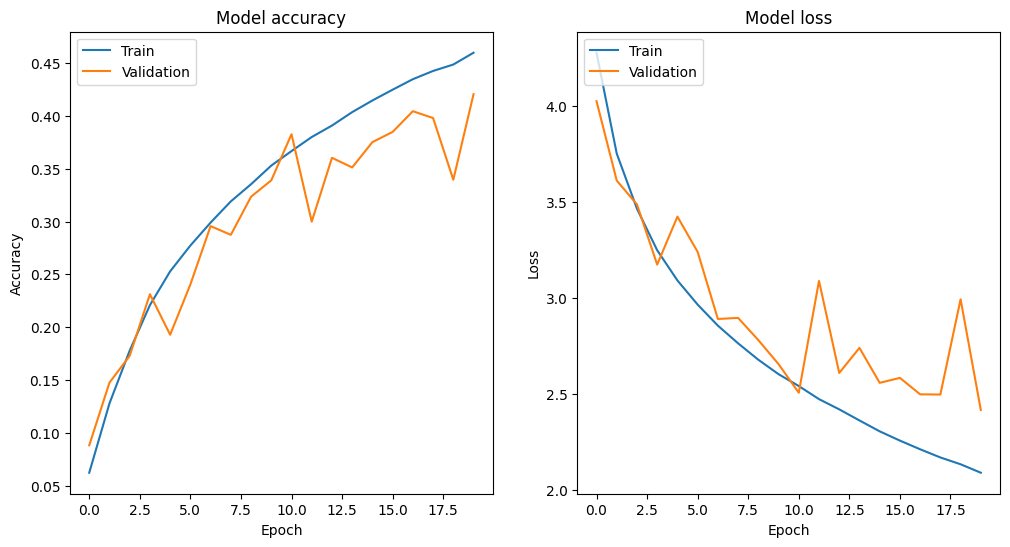

In [18]:
# Define CNN architecture 5

# Layer filter counts
num_conv1 = 32
num_conv2 = 64
num_conv3 = 128
num_hidden4 = 128
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size

model = Sequential([

    # Block 1
    Conv2D(num_conv1, kernel_size=(k_size, k_size), padding='same',
           kernel_initializer='he_normal', input_shape=(image_shape, image_shape, 3)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv1, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 2
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 3
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Classification Head
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    GlobalAveragePooling2D(),
    Dense(num_hidden4, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_output, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit the model to the data
num_epochs = 20

history = model.fit(
    cnn_train,
    validation_data=cnn_val,
    epochs=num_epochs
)

evaluate_model(model, history, cnn_test)

#### Architecture 6

This is similar to architecture 5 but uses only one convolutional layer per block.

In [ ]:
# Define CNN architecture 5

# Layer filter counts
num_conv1 = 32
num_conv2 = 64
num_conv3 = 128
num_hidden4 = 128
num_output = 101

num_convs = 4
image_shape = 128
k_size = 3          # kernel size
p_size = 2          # pool size

model = Sequential([

    # Block 1
    Conv2D(num_conv1, kernel_size=(k_size, k_size), padding='same',
           kernel_initializer='he_normal', input_shape=(image_shape, image_shape, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 2
    Conv2D(num_conv2, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Block 3
    Conv2D(num_conv3, kernel_size=(k_size, k_size),
           padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(p_size, p_size)),

    # Classification Head
    #   Hidden layer takes num_conv4 filters each of dimensions (image_shape // 2 ** num_convs, image_shape // 2 ** num_convs).
    #   This layer produces the final output.
    GlobalAveragePooling2D(),
    Dense(num_hidden4, kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),
    Dense(num_output, activation='softmax')
])

model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit the model to the data
num_epochs = 20

history = model.fit(
    cnn_train,
    validation_data=cnn_val,
    epochs=num_epochs
)

evaluate_model(model, history, cnn_test)

#### Architecture 7

This architecture uses MobileNetV2, a CNN architecture that is good for image recognition purposes like this, as the base.

In [15]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report

Epoch 1/5
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - accuracy: 0.2101 - loss: 3.4468 - val_accuracy: 0.4222 - val_loss: 2.3177
Epoch 2/5
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - accuracy: 0.3700 - loss: 2.5563 - val_accuracy: 0.4450 - val_loss: 2.2408
Epoch 3/5
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.3961 - loss: 2.4147 - val_accuracy: 0.4397 - val_loss: 2.2436
Epoch 4/5
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.4148 - loss: 2.3265 - val_accuracy: 0.4449 - val_loss: 2.2213
Epoch 5/5
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.4282 - loss: 2.2539 - val_accuracy: 0.4523 - val_loss: 2.2253
474/474 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4466 - loss: 2.2224
Test Loss: 2.2113, Test Accuracy: 0.4494


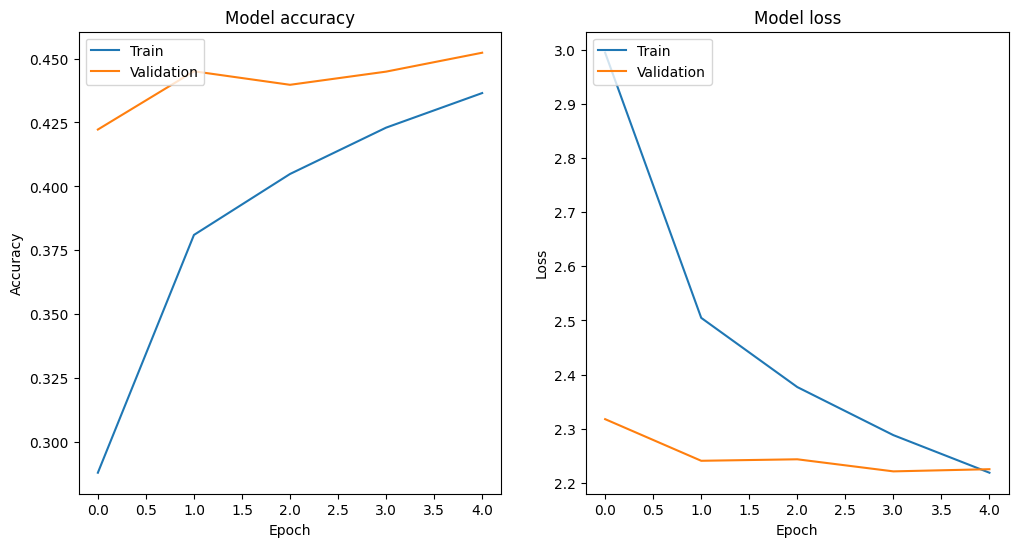

Epoch 1/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 116s 32ms/step - accuracy: 0.2257 - loss: 3.6281 - val_accuracy: 0.4283 - val_loss: 2.3279 - learning_rate: 1.0000e-05
Epoch 2/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 19ms/step - accuracy: 0.3712 - loss: 2.5862 - val_accuracy: 0.4642 - val_loss: 2.1679 - learning_rate: 1.0000e-05
Epoch 3/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.4245 - loss: 2.3185 - val_accuracy: 0.4944 - val_loss: 2.0396 - learning_rate: 1.0000e-05
Epoch 4/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - accuracy: 0.4578 - loss: 2.1421 - val_accuracy: 0.5114 - val_loss: 1.9680 - learning_rate: 1.0000e-05
Epoch 5/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.4825 - loss: 2.0180 - val_accuracy: 0.5215 - val_loss: 1.9201 - learning_rate: 1.0000e-05
Epoch 6/50
2210/2210 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.5037 - loss: 1.9211 - val_accuracy: 0.5335 - val_loss: 1.8653 - learning_rate: 1.0000e-05
Epoch 7/50
2210/2210 ━━━━━━━━━━━━━━━━━━

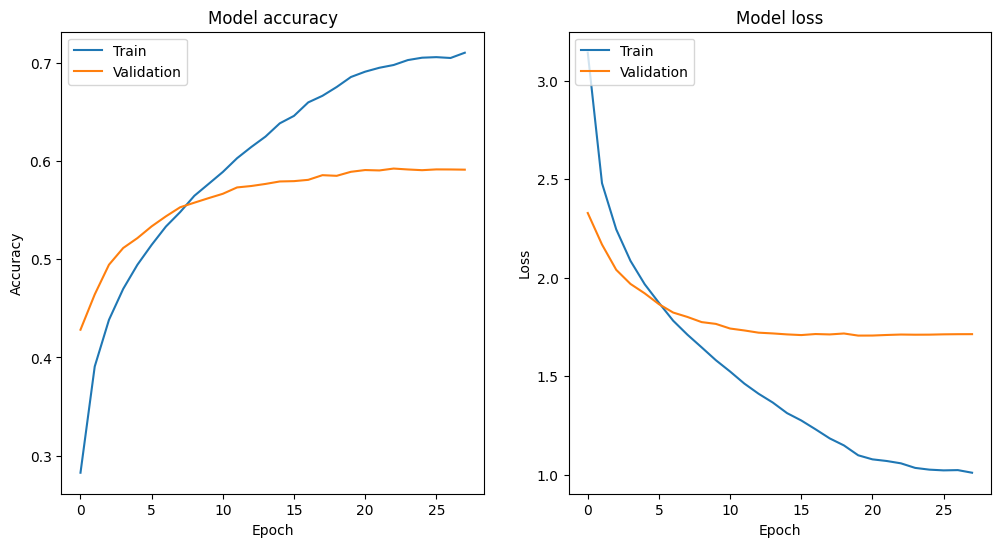

In [34]:
# Define CNN architecture 7

# Layer filter counts
num_hidden = 256
num_output = 101
image_shape = 128

# Best
num_epochs_warmup = 5
num_epochs_final = 50

# Initialize the MobileNetV2 base
base = MobileNetV2(
    input_shape=(image_shape, image_shape, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base for "fast-warmup", which should be ~5 epochs
base.trainable = False

# Warmup stage
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dense(num_hidden, activation='relu'),
    Dropout(0.4),
    Dense(num_output, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history1 = model.fit(
    mobilenet_train,
    validation_data=mobilenet_val,
    epochs=num_epochs_warmup
)

evaluate_model(model, history1, mobilenet_test)

# Fine-tuning stage
base.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Early stop callback
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    restore_best_weights=True
)

# Learning rate scheduler
lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

history2 = model.fit(
    mobilenet_train,
    validation_data=mobilenet_val,
    epochs=num_epochs_final,
    callbacks=[early_stop, lr]
)

evaluate_model(model, history2, mobilenet_test)

In [35]:
model.save('architecture7.keras')

Ensure the loaded model is evaluated correctly.

In [40]:
test_images = []
test_labels = []

for x, y in mobilenet_test.unbatch():
    test_images.append(x.numpy())
    test_labels.append(y.numpy())

test_images = np.stack(test_images)
test_labels = np.array(test_labels)

# Load the saved model
model = load_model("architecture7.keras")

# Predict
y_pred_probs = model.predict(test_images, batch_size=32)
y_pred = np.argmax(y_pred_probs, axis=1)

# Evaluate Saved Model
print(classification_report(test_labels, y_pred, target_names=class_names))
print(confusion_matrix(test_labels, y_pred))

474/474 ━━━━━━━━━━━━━━━━━━━━ 14s 21ms/step
                         precision    recall  f1-score   support

              apple_pie       0.33      0.31      0.32       150
         baby_back_ribs       0.63      0.69      0.66       150
                baklava       0.62      0.65      0.63       150
         beef_carpaccio       0.60      0.62      0.61       150
           beef_tartare       0.47      0.45      0.46       150
             beet_salad       0.50      0.55      0.53       150
               beignets       0.73      0.82      0.77       150
               bibimbap       0.73      0.77      0.75       150
          bread_pudding       0.34      0.38      0.36       150
      breakfast_burrito       0.43      0.44      0.44       150
             bruschetta       0.45      0.39      0.42       150
           caesar_salad       0.59      0.67      0.63       150
                cannoli       0.62      0.64      0.63       150
          caprese_salad       0.51      0.49  

In [39]:
# Count labels in the actual test_data as the model sees them
true_counts = np.zeros(101, dtype=int)

for _, labels in test_data:
    for y in labels.numpy():
        true_counts[y] += 1

print(true_counts)


[150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150 150
 150 150 150 150 150 150 150 150 150 150 150]


## Model 2 ViT

In [ ]:
# Pre process vit images
def vit_preprocess(image, label):
    # Resize from (128,128) → (224,224)
    image = tf.image.resize(image, (224, 224))

    # Convert [0,255] → [-1,1]
    image = (tf.cast(image, tf.float32) / 127.5) - 1.0

    return image, label

vit_train = train_data.map(vit_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
vit_val   = val_data.map(vit_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
vit_test  = test_data.map(vit_preprocess,  num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Download latest version
from keras.layers import TFSMLayer
import tensorflow as tf
import kagglehub

path = kagglehub.model_download("spsayakpaul/vision-transformer/tensorFlow2/vit-b8-classification")

print("Model saved at:", path)

# Load as inference-only layer
vit_layer = TFSMLayer(path, call_endpoint='serving_default')

# Wrap into a Model so you can call predict() and evaluate()
inputs = tf.keras.Input(shape=(224, 224, 3), dtype=tf.float32)
outputs = vit_layer(inputs)
model = tf.keras.Model(inputs, outputs)

In [ ]:
# WARNING this will take a while to run and blue screened my laptop last time
model.summary()
preds = model.predict(vit_test)
# Calculate performance
loss, accuracy = model.evaluate(vit_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")